# Description

This notebook demonstrates the performance of various operations using Pandas and Polars libraries in Python concerning the time taken. These libraries play a critical role in data analysis for mid-sized datasets, where the speed of task completion is of utmost importance while maintaining flexibility and ease of use.

For the tasks below, a public dataset from https://grouplens.org/datasets/movielens/ is utilized, containing approximately 25 million rows and having a data size of 662,365KB in raw text format. The dataset consists of columns such as userId, movieId, rating, and timestamp.

The "userId" field contains 162,541 unique entries, and the "movieId" field contains 59,047 unique movies. The "rating" column indicates user feedback on a scale of 1 to 5 for the corresponding movie.

# Imports

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import time
import gzip
import datetime
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()


# Utility Functions 
Used to perform tasks

In [2]:
def getDayOfWeek(ratingTimestamp):
    return datetime.datetime.fromtimestamp(ratingTimestamp).weekday()

def percent_changes(pd_time,pl_time):
    return round((pl_time-pd_time)/pl_time*100,2)

def timeTaken(statTime):
    return round(time.time() - startTime,2)

#  Metrics

In [3]:
statsDict = {}

statsList = ["readTime","rawWriteTime","zipWriteTime","parquetWriteTime","describeTime","groupbyTime","filterTime","transfromTime"]

for stats in statsList:
    statsDict[stats] = {"pd_"+stats:"","pl_"+stats:""}

#  Reading Dataset

In [4]:
startTime = time.time()
df_pd = pd.read_csv("./ml-25m/ml-25m/ratings.csv",engine="pyarrow")
statsDict["readTime"]["pd_readTime"] = timeTaken(startTime)

In [5]:
startTime = time.time()
df_pl = pl.read_csv("./ml-25m/ml-25m/ratings.csv")
statsDict["readTime"]["pl_readTime"] = timeTaken(startTime)

# Writing to raw csv format 

In [6]:
startTime = time.time()
df_pd.to_csv("test_pd.csv",index=False)
statsDict["rawWriteTime"]["pd_rawWriteTime"] = timeTaken(startTime)

In [7]:
startTime = time.time()
df_pl.write_csv("test_pl.csv")
statsDict["rawWriteTime"]["pl_rawWriteTime"] = timeTaken(startTime)

# Writing to parquet format with snapp compression 

In [8]:
startTime = time.time()
df_pd.to_parquet("test_pd.parquet",compression="snappy")
statsDict["parquetWriteTime"]["pd_parquetWriteTime"] = timeTaken(startTime)

startTime = time.time()
df_pl.write_parquet("test_pl.parquet",compression="snappy")
statsDict["parquetWriteTime"]["pl_parquetWriteTime"] = timeTaken(startTime)


# Writing to csv using gzip compression

In [9]:
startTime = time.time()
df_pd.to_csv("test_pd.csv.gz",index=False,compression="gzip")
statsDict["zipWriteTime"]["pd_zipWriteTime"] = timeTaken(startTime)

startTime = time.time()
with gzip.open("test_pl.csv.gzip", 'wb') as f:
    df_pl.write_csv(f)
statsDict["zipWriteTime"]["pl_zipWriteTime"] = timeTaken(startTime)

# Running describe 
Describe is used quite heavly when performing explorotary analysis

In [10]:
startTime = time.time()
df_pd.describe()
statsDict["describeTime"]["pd_describeTime"] = timeTaken(startTime)

startTime = time.time()
df_pl.describe()
statsDict["describeTime"]["pl_describeTime"] = timeTaken(startTime)

#  Groupby 

Generating aggregate to understand frequency of ratings provided by each users along with min and max ratings.

In [11]:
startTime = time.time()
tmp_df_pd = df_pd.groupby("userId")["rating"].agg({"count","min","max"})
statsDict["groupbyTime"]["pd_groupbyTime"] = timeTaken(startTime)

startTime = time.time()
tmp_df_pl = df_pl.groupby("userId").agg(
    pl.count("rating").alias("count"),
    pl.col("rating").min().alias("min"),
    pl.col("rating").max().alias("max")
).sort("userId", descending=False)
statsDict["groupbyTime"]["pl_groupbyTime"] = timeTaken(startTime)

In [12]:
tmp_df_pl.head()

userId,count,min,max
i64,u32,f64,f64
1,70,0.5,5.0
2,184,0.5,5.0
3,656,2.0,5.0
4,242,0.5,5.0
5,101,2.0,5.0


In [13]:
tmp_df_pd  =tmp_df_pd[["count","min","max"]]
tmp_df_pd.head()

,count,min,max
userId,,,
1,70,0.5,5.0
2,184,0.5,5.0
3,656,2.0,5.0
4,242,0.5,5.0
5,101,2.0,5.0


# Filter Movie rating dataset


In [14]:
startTime = time.time()
tmp_df_pd = df_pd[df_pd["rating"] >= 4 ]
statsDict["filterTime"]["pd_filterTime"] = timeTaken(startTime)

startTime = time.time()
tmp_df_pl = df_pl.filter(pl.col("rating") >= 4 )
statsDict["filterTime"]["pl_filterTime"] = timeTaken(startTime)

In [15]:
print("Size of dataset after filtering: \nLength with Polars:{}\nLength with Pandas:{}".format(len(tmp_df_pl),len(tmp_df_pd)))

Size of dataset after filtering: 
Length with Polars:12452811
Length with Pandas:12452811


# Transforming 

Apply a custom function to a column converting timestamp in seconds to day of week in integer format

In [16]:

startTime = time.time()
df_pd["WeekDayOfRating"] = df_pd["timestamp"].apply(lambda x : getDayOfWeek(x))
statsDict["transfromTime"]["pd_transfromTime"] = timeTaken(startTime)


startTime = time.time()
df_pl=df_pl.with_columns([(pl.col("timestamp").apply(lambda x: getDayOfWeek(x)).alias('WeekDayOfRating'))])
statsDict["transfromTime"]["pl_transfromTime"] = timeTaken(startTime)

# Plot Metrics using matplotlib bar chart 

In [23]:
def compare_runtimes(statsDict, exclude="rawWrite"):
    pandas_times = {}
    polars_times = {}
    for key in statsDict.keys():
        for module in statsDict[key].keys():
            tmp =  module.replace("Time","").split("_")
            if(exclude not in tmp):
                if("pd" in module):pandas_times[tmp[1]] = statsDict[key][module]
                elif("pl" in module):polars_times[tmp[1]] = statsDict[key][module]

    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(12, 10))

  # Setting the title and labels for the graph
    ax[0].set_title("Compare time taken for tasks using Pandas and Polars")
    ax[0].set_xlabel("Tasks")
    ax[0].set_ylabel("Time (Seconds)")

  # Creating a bar graph for Pandas and Polars runtimes
    operations = pandas_times.keys()
    num_operations = len(operations)
    bar_width = 0.35
    pandas_x = np.arange(num_operations)
    polars_x = pandas_x + bar_width

    pandas_y = list(pandas_times.values())
    polars_y = list(polars_times.values())

    pandas_bar = ax[0].bar(pandas_x, pandas_y, bar_width, color='tab:blue', label='Pandas')
    polars_bar = ax[0].bar(polars_x, polars_y, bar_width, color='tab:orange', label='Polars')

  # Setting the x-axis ticks and labels
    ax[0].set_xticks(pandas_x + bar_width / 2)
    ax[0].set_xticklabels(operations)

  # Setting the y-axis limit as the maximum of the two maximum values of runtimes
    ax[0].set_ylim(0, max(max(pandas_y), max(polars_y)) * 1.2)

  # Adding values on top of the bars
    for i, bars in enumerate(zip(pandas_bar, polars_bar)):
        for bar in bars:
            height = bar.get_height()
            ax[0].annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

  # Adding a legend to the graph
    ax[0].legend()
    
    ax[1].set_title("Percentage Time Reduced with Polars compared to Pandas")
    ax[1].set_xlabel("Tasks")
    ax[1].set_ylabel("Percentage Time Reduced")
    
    percents = []
    for pd_operationTime, pl_operationTime in zip(pandas_y,polars_y):
        percents.append(percent_changes(pd_operationTime,pl_operationTime))

    bars = ax[1].bar(pandas_x, percents, bar_width, color='tab:blue')
    ax[1].set_xticks(pandas_x + bar_width / 2)
    ax[1].set_xticklabels(operations)
    ax[1].set_ylim(0, min(min(percents), min(percents)) * 1.2)
    for bar in bars:
        height = bar.get_height()
        ax[1].annotate(f"{height:.2f}%", xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    
  # Displaying the graph
#     fig.tight_layout()
    fig.tight_layout(pad=5.0)
    plt.show()

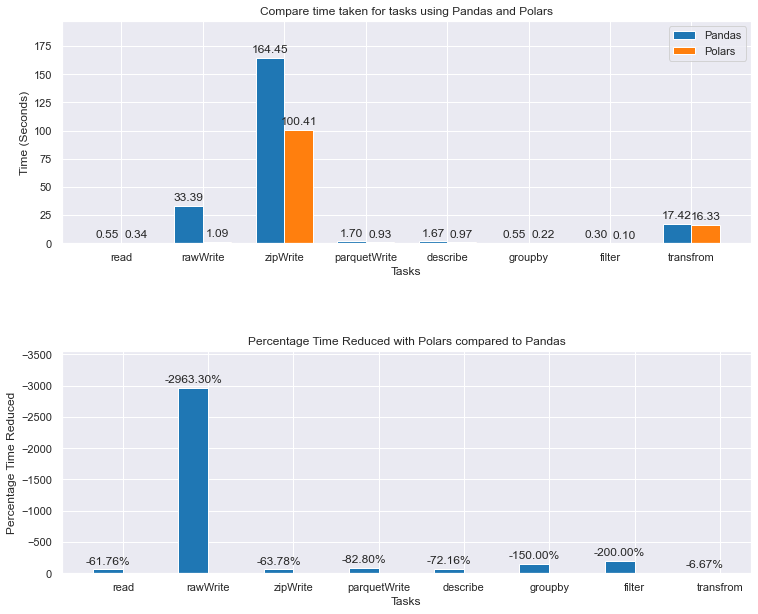

In [24]:
compare_runtimes(statsDict,exclude="")

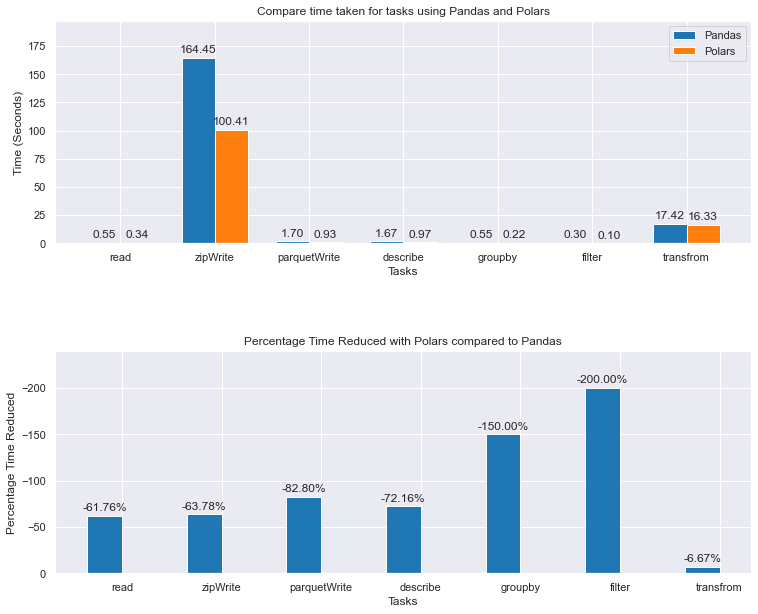

In [25]:
compare_runtimes(statsDict)

In [26]:
df_pd.userId.nunique()

162541

In [21]:
df_pd.movieId.nunique()

59047